In [42]:
import pandas as pd
import json
import matplotlib.pyplot as plt

Loading the dataset

In [43]:
df = pd.read_csv("version1.csv")

# Looking at NA Values in the Dataset

In [44]:
df.isna().sum()

Unnamed: 0                 0
index                      0
budget                     0
genres                    28
homepage                3089
id                         0
keywords                 412
original_language          0
original_title             0
overview                   1
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    0
spoken_languages           0
status                     0
tagline                  842
title                      0
vote_average               0
vote_count                 0
cast                      43
crew                       0
director                  30
dtype: int64

Doing the data anlaysis on the release date column. I created some extra columns as Year, Month inorder to explore the revenue and more.

In [45]:
df['release_date'].describe()

count           4800
unique          3279
top       2006-01-01
freq              10
Name: release_date, dtype: object

# Cleaning - Treating the null and na values in the release data columns

In [46]:
df['release_date'].isna().sum()


1

In [47]:
#dropping the NA rows
x=df[df['release_date'].isna()].index
df=df.drop(x)

#Temporal Analysis - creating new columns year, month for each movie.

In [48]:
#separating the year and month from the release_date column into the year and month separrate column
df['release_date'].isna().sum()
df['year'] = pd.DatetimeIndex(df['release_date']).year
df['month'] = pd.DatetimeIndex(df['release_date']).month
df['year'] = df['year'].astype(int)
df['month']=df['month'].astype(int)

#Removing the $ etc symbols


In [49]:
# Convert revenue column
def convert_revenue(x):
    if isinstance(x, str) and '$' in x:
        x = float(x.replace('$', '').replace(',', ''))
    return x / 100

df['revenue'] = df['revenue'].apply(convert_revenue)

Tranforming the hours minutes into redable

In [50]:
def convert_runtime(x):
    if isinstance(x, str) and 'h' in x:
        parts = x.split()
        if len(parts) == 2:
            hours = int(parts[0].replace('h', ''))
            minutes = int(parts[1].replace('m', ''))
            return hours * 60 + minutes
    return x

df = df.dropna(subset=['runtime'])
df['runtime'] = df['runtime'].apply(convert_runtime)

# **EDA - Release Date**

---


# Time Series Plot (Number of Releases per Year)

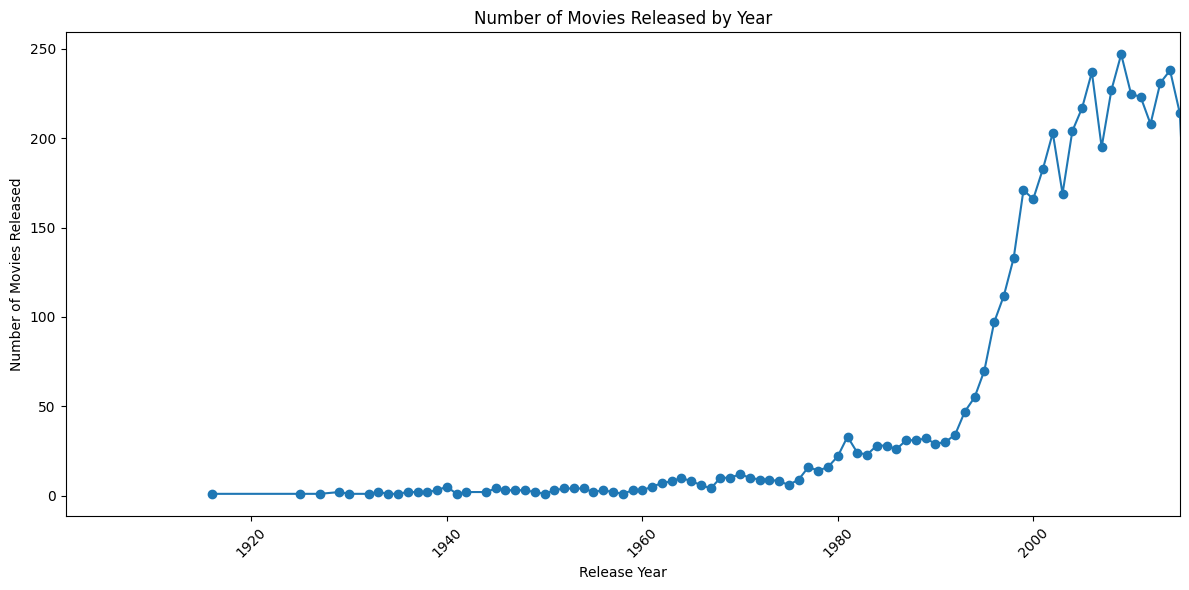

In [51]:
yearly_movie_count = df['year'].value_counts().sort_index()
yearly_movie_count = yearly_movie_count[yearly_movie_count > 0]
# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(yearly_movie_count.index, yearly_movie_count.values, marker='o')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released by Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(1901, 2015)
plt.show()

# : Histogram and Distribution - Release Date frequency

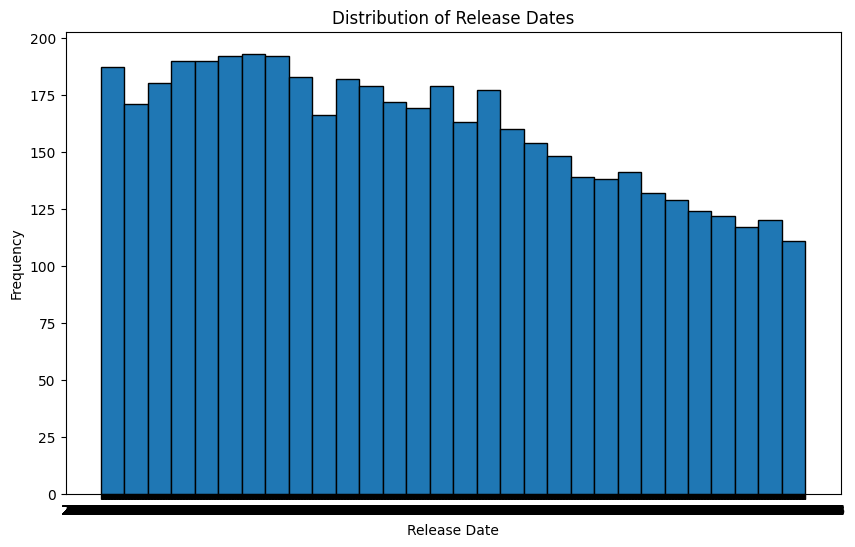

In [52]:
# Create a histogram of release dates
plt.figure(figsize=(10, 6))
plt.hist(df['release_date'], bins=30, edgecolor='k')
plt.xlabel('Release Date')
plt.ylabel('Frequency')
plt.title('Distribution of Release Dates')
plt.show()


# Seasonality Analysis Monthly

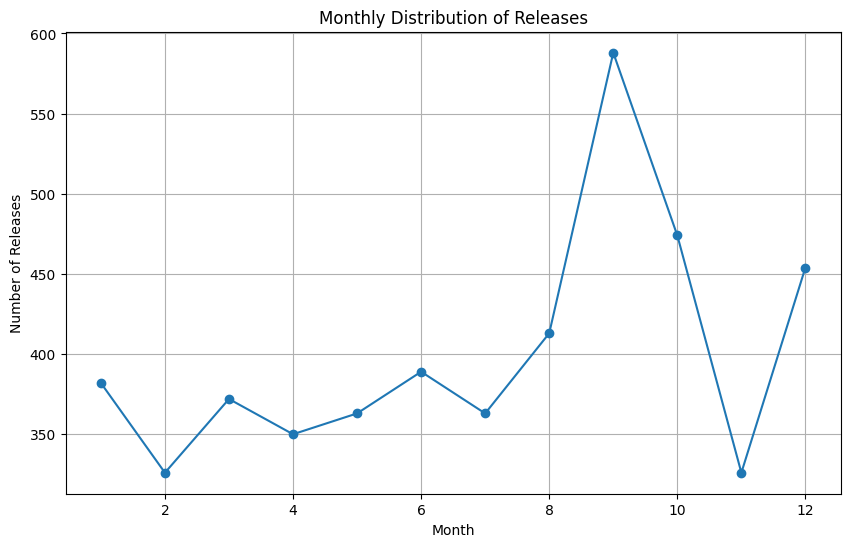

In [53]:
# Group data by month and calculate the average number of releases per month
monthly_release_counts = df.groupby('month')['year'].count()
plt.figure(figsize=(10, 6))
plt.plot(monthly_release_counts.index, monthly_release_counts.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.title('Monthly Distribution of Releases')
plt.grid(True)
plt.show()


# Outlier Detection

In [54]:
# Check for outliers in release dates
outliers = df[(df['release_date'] < '1900-01-01') | (df['release_date'] > '2022-12-31')]
outliers

,Unnamed: 0,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,...,status,tagline,title,vote_average,vote_count,cast,crew,director,year,month


# Weekend vs. Weekday Releases
 based on the  t-statistic and p-value, there is evidence  that there is a significant difference in movie revenue between weekday and weekend releases, with weekend releases having a higher mean revenue.

In [55]:
from scipy import stats
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Check if the conversion was successful
if 'release_date' in df.columns:
    # Create a new column to indicate if the release date is on a weekend (1) or weekday (0)
    df['is_weekend'] = df['release_date'].dt.weekday >= 5

    # Perform a t-test to compare the revenue of weekend releases vs. weekday releases
    weekend_revenue = df[df['is_weekend']]['revenue']
    weekday_revenue = df[~df['is_weekend']]['revenue']
    t_statistic, p_value = stats.ttest_ind(weekend_revenue, weekday_revenue)
else:
    print("Error: 'release_date' column not found or could not be converted to datetime.")

In [72]:
t_statistic, p_value

(-3.139337589399419, 0.001703581856420019)

# Data Cleaning


Created the new languages count column using the spoken languages column

In [56]:
df['spoken_languages'].isna().sum()

0

In [57]:
df['spoken_languages'][0]

'[{"iso_639_1": "en", "name": "English"}, {"iso_639_1": "es", "name": "Espa\\u00f1ol"}]'

In [58]:
#Created the new languages count column using the spoken languages
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: json.loads(x))
df['Languages_count'] = df['spoken_languages'].apply(lambda x: len(x))

Languages frequency - Movies

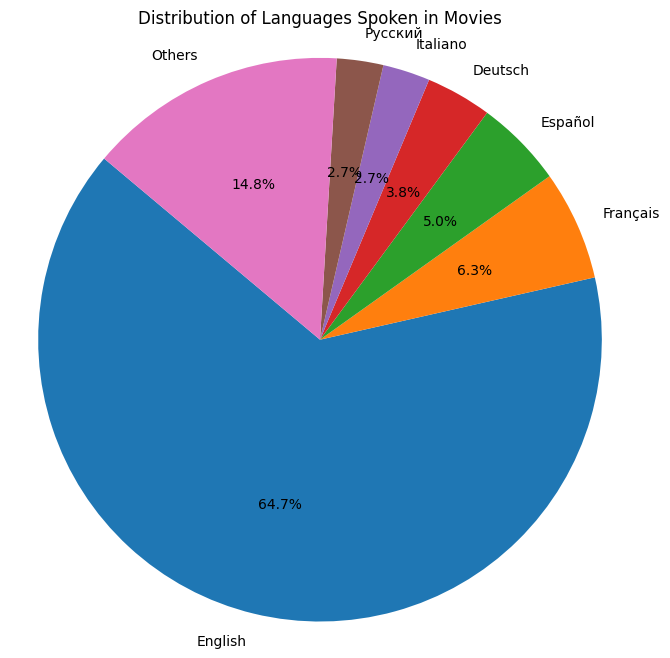

In [59]:
languages = []
for lang_list in df['spoken_languages']:
    for lang_dict in lang_list:
        languages.append(lang_dict['name'])


language_counts = pd.Series(languages).value_counts()
threshold = 0.02 * len(languages)
language_counts['Others'] = language_counts[language_counts < threshold].sum()
language_counts = language_counts[language_counts >= threshold]


# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Languages Spoken in Movies')

# Show the plot
plt.show()

# Language Trends over Years

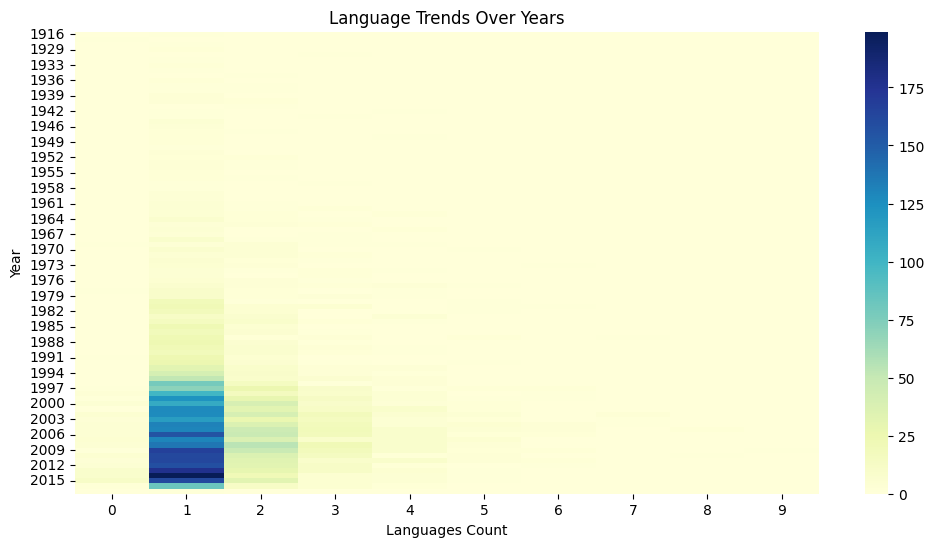

In [60]:
import seaborn as sns

# Pivot the data to get language trends over years
language_year = df.pivot_table(index='year', columns='Languages_count', values='index', aggfunc='count', fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(language_year, cmap='YlGnBu')
plt.xlabel('Languages Count')
plt.ylabel('Year')
plt.title('Language Trends Over Years')
plt.show()


# **Data Cleaning, tranformation**

Created new columns for the productions companies count and their respective countries count as well for each movie.

In [61]:
df['production_companies'].isna().sum()
df['production_countries'].isna().sum()

0

In [62]:
#created new productions producers count column from the production companies
df['production_companies']=df['production_companies'].apply(lambda x: json.loads(x))
df['productions_count']=df['production_companies'].apply(lambda x: len(x))
#created new productions countries count column from the production countries column
df['production_countries']=df['production_countries'].apply(lambda x: json.loads(x))
df['productions_countries_count']=df['production_countries'].apply(lambda x: len(x))

bar plots side by side to visualize the counts of production companies and production countries per movie

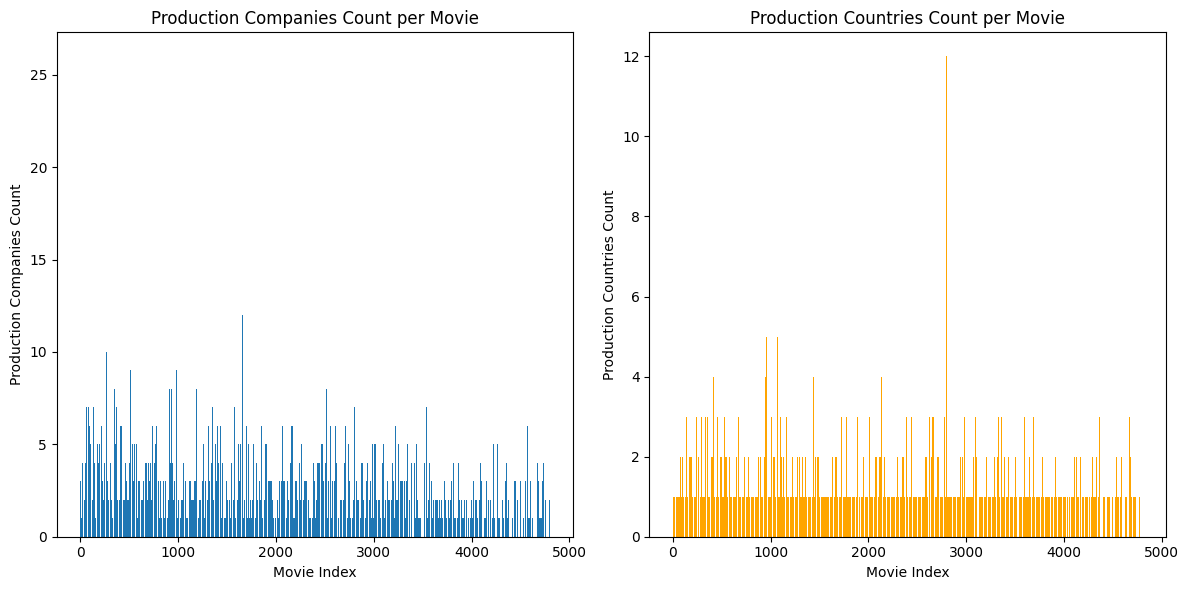

In [63]:
plt.figure(figsize=(12, 6))

# Bar plot for production companies count
plt.subplot(1, 2, 1)
plt.bar(df.index, df['productions_count'])
plt.xlabel('Movie Index')
plt.ylabel('Production Companies Count')
plt.title('Production Companies Count per Movie')

# Bar plot for production countries count
plt.subplot(1, 2, 2)
plt.bar(df.index, df['productions_countries_count'], color='orange')
plt.xlabel('Movie Index')
plt.ylabel('Production Countries Count')
plt.title('Production Countries Count per Movie')

plt.tight_layout()
plt.show()


# Movie runtime vs revenue

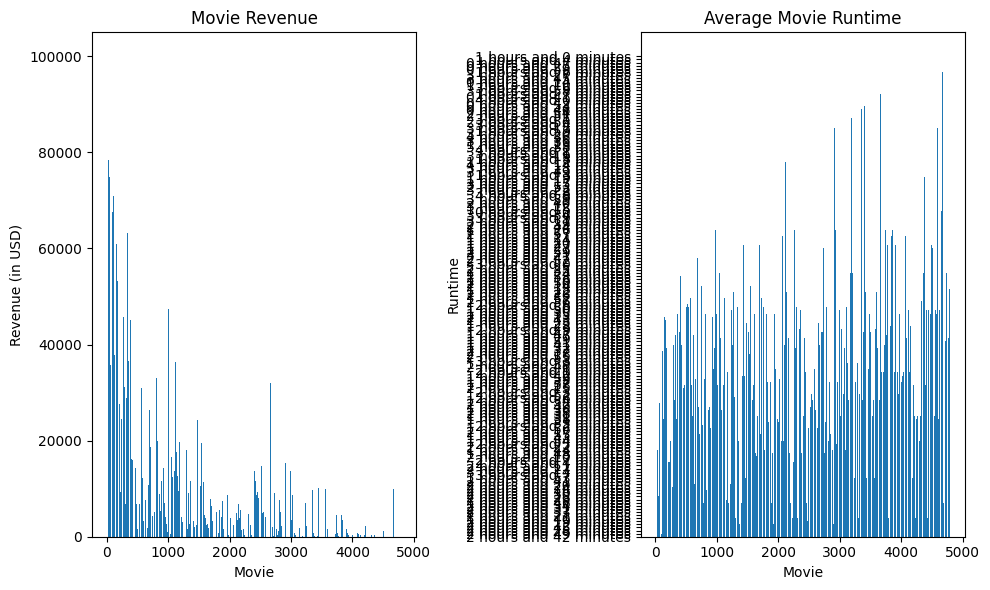

In [71]:
plt.figure(figsize=(10, 6))

#  Movie Revenue
plt.subplot(1, 2, 1)
plt.bar(df.index, df['revenue'])
plt.xlabel('Movie')
plt.ylabel('Revenue (in USD)')
plt.title('Movie Revenue')
plt.ylim(0, 105000)  # Set the y-axis limits to 0 to 100,000

# Subplot 2: Average Movie Runtime
plt.subplot(1, 2, 2)
plt.bar(df.index, df['runtime'])
plt.xlabel('Movie')
plt.ylabel('Runtime')
plt.title('Average Movie Runtime')
plt.tight_layout()
plt.show()
